In [1]:
import os
import sklearn 
import numpy as np
import pandas as pd
from scipy.io import loadmat
import spectral as spy
import PIL.Image as Image
import seaborn as sns
from skimage import filters
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

# 高光谱图像处理分割

In [2]:
input_image = loadmat(r'C:/Users/87758/Desktop/Project_final/Dataset_Image_University.mat')['DataTest']

In [3]:
gt_image = loadmat(r'C:/Users/87758/Desktop/Project_final/University_groundtruth_map.mat')['map']

In [4]:
gt_image.shape

(610, 340)

### 高光谱图像降维及可视化

In [5]:
image = input_image.reshape(610,340,103)

任选其中三个维度

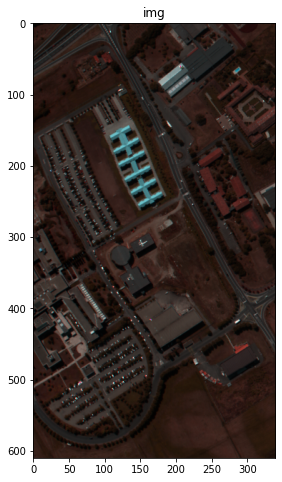

In [6]:
view1 = spy.imshow(data=image, bands=[69, 27, 20], title="img",figsize=(8,8))

统计一下每类样本中所含的个数

In [7]:
pd.DataFrame(pd.Series(gt_image.reshape(-1,)).value_counts()).T

,0,2,1,6,8,4,3,5,7,9
0,164624,18649,6631,5029,3682,3064,2099,1345,1330,947


In [8]:
ksc_color =np.array([[255,255,255],
     [184,40,99],
     [74,77,145],
     [35,102,193],
     [238,110,105],
     [117,249,76],
     [114,251,253],
     [126,196,59],
     [234,65,247],
     [141,79,77],
     [183,40,99],
     [0,39,245],
     [90,196,111],
        ])

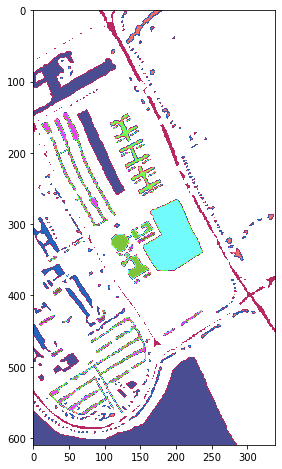

In [9]:
# 展示地物
ground_truth = spy.imshow(classes = gt_image.astype(int),figsize =(8,8),colors=ksc_color)

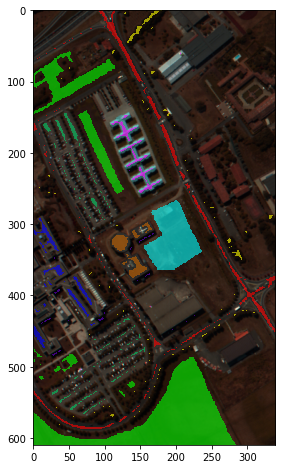

In [10]:
view3 = spy.imshow(data=image, bands=[69, 27, 11], classes=gt_image,figsize=(8,8))
view3.set_display_mode("overlay")
view3.class_alpha = 0.6

In [11]:
column_names = np.arange(103)

In [12]:
column_names = list(map(lambda x:str(x)+'_dimension',list(column_names)))

In [13]:
pd1 = pd.DataFrame(input_image)

In [373]:
def feature_score(input_dataframe,flags=False,root=None):
    ####相关分析的特征重要度
    corr_matrix=input_dataframe.iloc[:,:]
    corr_matrix=corr_matrix.corr()
    corr_feature_importance=corr_matrix['label'].sort_values(ascending=False)
    corr_feature_score=pd.DataFrame(abs(corr_feature_importance))
    ####利用随机森林的特征重要度进行数据降低维度
    print("corr analysis has been done")
    rnd_dataframe=input_dataframe.iloc[:,:]
    rnd_dataframe.reset_index(inplace=True)
    split=StratifiedShuffleSplit(n_splits=1,test_size=0.08,random_state=42)
    for train_index,test_index in split.split(input_dataframe,input_dataframe['label']):
        strat_train_set=rnd_dataframe.loc[train_index]
        strat_test_set=rnd_dataframe.loc[test_index]
    strat_test_set.sort_index(inplace=True)
    strat_train_set.sort_index(inplace=True)
    std=StandardScaler()
    feature_columns=list(rnd_dataframe.columns[:-1])
    print(feature_columns)
    X_train=strat_train_set[feature_columns]
    X_train=std.fit_transform(X_train)
    y_train=np.array(strat_train_set['label'])
    X_test=strat_test_set[feature_columns]
    X_test=std.fit_transform(X_test)
    y_test=np.array(strat_test_set['label'])
    rnd_clf= RandomForestClassifier(n_estimators=1000,max_leaf_nodes=16,n_jobs=-1)
    rnd_clf.fit(X_train,y_train) 
    rnf_feature_score=pd.DataFrame(rnd_clf.feature_importances_)
    rnf_feature_score.index=feature_columns
    print("feature importance has been done")
    #####合并两个特征数据,函数输出的是DataFrame的数据格式的
    feature_df=pd.merge(rnf_feature_score,corr_feature_score,left_index=True,right_index=True)
    feature_df.dropna(how='any',inplace=True)
    feature_df.columns=['Feature_importance','corr_importance']
    feature_df["score"]=feature_df['Feature_importance']*0.7+feature_df['corr_importance']*0.3
    feature_df.sort_values(by='score',ascending=False,inplace=True)
    formater="{0:.06f}".format
    feature_df=feature_df.applymap(formater)
    print("two DataFrame have been merged correctly")
    feature_df.apply(np.float64)
    if flags:
        feature_df.to_csv(os.path.join(root,"feature_df.csv"))
    return feature_df

In [374]:
pd1

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,647,499,464,371,291,319,365,322,296,305,...,3420,3416,3335,3256,3226,3205,3210,3221,3238,3250
1,604,546,527,455,378,377,336,314,324,329,...,2605,2583,2538,2509,2511,2501,2468,2442,2464,2528
2,621,746,556,360,285,300,274,276,332,319,...,2282,2288,2242,2193,2202,2225,2266,2308,2345,2361
3,637,592,482,556,508,284,178,198,193,224,...,2684,2675,2609,2541,2551,2571,2569,2573,2620,2644
4,625,560,480,360,377,341,264,208,231,266,...,2423,2392,2344,2289,2328,2415,2424,2386,2431,2456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,574,594,504,411,468,443,378,342,352,434,...,2130,2150,2157,2157,2169,2151,2108,2077,2076,2136
207396,485,644,709,582,504,494,434,373,391,421,...,2218,2264,2295,2282,2265,2275,2293,2274,2274,2258
207397,593,387,428,461,470,392,331,383,439,355,...,2384,2393,2407,2433,2413,2373,2389,2382,2407,2423
207398,593,751,655,458,503,560,482,412,404,454,...,2338,2340,2333,2332,2288,2251,2280,2312,2308,2289


主成分分析，

In [375]:
def pca_dr(src):
    pc = spy.principal_components(src)
    pc_98 = pc.reduce(fraction=0.98)  # 保留98%的特征值
    print(len(pc_98.eigenvalues))  # 剩下的特征值数量
    sns.heatmap(data=pc.cov,cmap = 'RdBu')
    img_pc = pc_98.transform(input_image)  # 把数据转换到主成分空间
    img_pc = image.reshape(610,340,-1)
     # 前三个主成分显示
    return img_pc


3


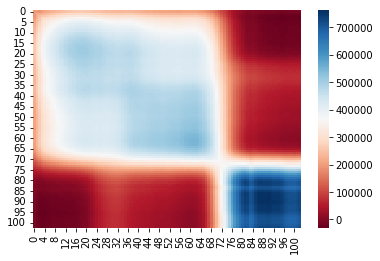

In [376]:
img_pca = pca_dr(image)[:,:,:]

In [377]:
img_pca.shape

(610, 340, 103)

In [378]:
img_pca[:, :, :3].shape

(610, 340, 3)

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 8000.0]
    G: [0.0, 8000.0]
    B: [0.0, 8000.0]

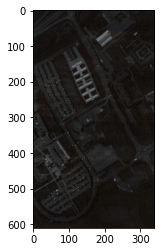

In [379]:
spy.imshow(img_pca[:, :, :3], stretch_all=True) 

In [380]:
def lda_dr(src, gt):
    classes = spy.create_training_classes(src, gt)
    fld = spy.linear_discriminant(classes)
    print(len(fld.eigenvalues))
    img_fld = fld.transform(src)
    print(img_fld.shape)
    spy.imshow(img_fld[:, :, :3])
    return img_fld


8
(610, 340, 8)


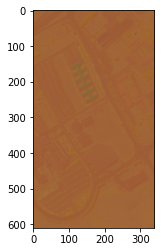

In [381]:
lda_img = lda_dr(image,gt_image)

In [382]:
lda_img[0]

array([[ 1.61384247,  1.32132946, -8.45156149, ..., -0.57555096,
        -1.54219408,  0.49683742],
       [ 0.51809062, -0.88267644, -6.30203714, ..., -0.71949742,
        -1.22688559,  0.93360127],
       [ 0.17264197,  0.23718406, -4.36958735, ...,  1.26017546,
        -1.26495102,  0.40977829],
       ...,
       [ 1.4734013 ,  3.11359958,  1.82354552, ..., -0.06475713,
         0.84170474,  0.71438324],
       [ 0.8507176 ,  2.88457101,  1.21905135, ...,  2.38425524,
         1.19220071, -1.16446492],
       [ 1.07382783,  2.04240916,  2.1994525 , ...,  0.71164821,
        -0.0490925 ,  1.33425426]])

#### Gabor

In [383]:
test_img = image[:,:,-1]

In [384]:
real, imag = filters.gabor(test_img, frequency=0.6,theta=45,n_stds=5)
img_mod=np.sqrt(real.astype(float)**2+imag.astype(float)**2)

利用LDA的数据降维的思路进行，

In [385]:
np.linspace(0.1,0.5,5)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [386]:
origrin_array = np.array(pd1.iloc[:,:-1])

In [387]:
results = []
kernel_params = []
index = 0
middle_lda = sklearn_lda.transform(origrin_array)
middle_lda = middle_lda.reshape(610,340,-1)
for i in range(8):  
    for theta in range(0,4):
        theta = theta / 4. * np.pi
        for frequency in np.linspace(0.1,0.3,5):
            real,mod = filters.gabor(middle_lda[:,:,i],frequency=frequency,theta = theta)
            print('theta=%d,\nfrequency=%.2f,%d th channel' % (theta * 180 / np.pi, frequency,i))
            new_img = np.sqrt(real.astype(float)**2+imag.astype(float)**2)
            results.append(new_img)

ValueError: X has 102 features, but LinearDiscriminantAnalysis is expecting 103 features as input.

#### 集成GLCM和LBP 两种方式

In [14]:
import sklearn

#### 基于XGBOOST的高光谱遥感地物分类

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sk
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #sklearn xgboost  #Additional     scklearn functions  #Perforing grid search

除掉0这一非分类的类，将所有需要分类的数据的元素提取出来

In [28]:
import sklearn

In [29]:
output_image = gt_image

In [30]:
output_image.shape

(610, 340)

将训练数据中未被标记的去掉

In [31]:
pd1['label'] = output_image.reshape(-1,)

In [32]:
pd1

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,label
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,574,594,504,411,468,443,378,342,352,434,...,2150,2157,2157,2169,2151,2108,2077,2076,2136,0
207396,485,644,709,582,504,494,434,373,391,421,...,2264,2295,2282,2265,2275,2293,2274,2274,2258,0
207397,593,387,428,461,470,392,331,383,439,355,...,2393,2407,2433,2413,2373,2389,2382,2407,2423,0
207398,593,751,655,458,503,560,482,412,404,454,...,2340,2333,2332,2288,2251,2280,2312,2308,2289,0


对比实验,没有降低维度和PCA处理之后的维度

In [33]:
train_data = pd1[pd1['label']!=0]
train_array = np.array(train_data)

In [34]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,label
91,1447,1113,973,1053,1180,1263,1285,1320,1283,1295,...,1788,1749,1696,1708,1714,1698,1660,1643,1610,1
92,1203,1304,1402,1525,1586,1560,1461,1430,1434,1453,...,1103,1096,1113,1164,1167,1109,1075,1126,1182,1
93,1579,1498,1299,1208,1251,1282,1291,1257,1221,1183,...,1116,1100,1116,1122,1138,1146,1137,1145,1161,1
94,562,850,1020,1075,1008,914,992,998,929,930,...,2122,2112,2144,2142,2109,2135,2139,2130,2122,1
95,1188,1174,1189,1383,1451,1433,1452,1486,1518,1520,...,1749,1728,1683,1651,1620,1582,1556,1574,1620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207341,911,1038,1026,879,798,889,904,784,839,921,...,2632,2640,2651,2644,2629,2632,2629,2635,2634,2
207342,962,764,802,862,894,951,934,883,858,799,...,2705,2712,2722,2688,2644,2628,2629,2627,2681,2
207343,758,439,489,694,812,789,733,753,822,862,...,2799,2818,2828,2800,2737,2753,2751,2734,2720,2
207344,1000,741,802,887,946,958,870,835,872,852,...,2988,3006,3008,2929,2844,2836,2870,2895,2899,2


In [35]:
feature_df = feature_score(train_data)

NameError: name 'feature_score' is not defined

In [36]:
feature_df

NameError: name 'feature_df' is not defined

In [37]:
feature_df.apply(np.float64).describe()

NameError: name 'feature_df' is not defined

In [38]:
import skimage

In [39]:
feature_df.describe()

NameError: name 'feature_df' is not defined

这步开始实际的降维处理

In [40]:
np.unique(train_array[:,-1])

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16)

In [41]:
pd1

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,label
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,574,594,504,411,468,443,378,342,352,434,...,2150,2157,2157,2169,2151,2108,2077,2076,2136,0
207396,485,644,709,582,504,494,434,373,391,421,...,2264,2295,2282,2265,2275,2293,2274,2274,2258,0
207397,593,387,428,461,470,392,331,383,439,355,...,2393,2407,2433,2413,2373,2389,2382,2407,2423,0
207398,593,751,655,458,503,560,482,412,404,454,...,2340,2333,2332,2288,2251,2280,2312,2308,2289,0


In [42]:
### LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
sklearn_lda = LinearDiscriminantAnalysis()
sklearn_lda.fit(train_array[:,:-1],train_array[:,-1])
Lda_data = sklearn_lda.transform(train_array[:,:-1])

In [43]:
Lda_output = sklearn_lda.transform(np.array(pd1.iloc[:,:-1]))

In [44]:
Lda_img = Lda_output.reshape(610,340,8)

In [45]:
from skimage.feature import greycomatrix, greycoprops

mat文件的保存格式

In [46]:
import scipy.io

In [26]:
scipy.io.savemat('Lda_mat.mat',{'Lda':Lda_output})

NameError: name 'Lda_output' is not defined

In [48]:
GLCM_feature = loadmat(r'E:/GLCM_mat.mat')['Feature']

In [49]:
GLCM_feature.shape

(610, 340, 96)

In [50]:
Gabor_feature = np.array(loadmat(r'E:/Gabor.mat')['Feature_P'])

In [51]:
Gabor_feature.shape

(610, 340, 32)

In [52]:
LBP_feature = np.array(loadmat(r'E:/LBP_Global.mat')['F_P'])

In [53]:
LBP_feature.shape

(610, 340, 472)

In [ ]:
LBP_Gabor_Lda_feature = np.concatenate([Gabor_feature,LBP_feature,Lda_img,GLCM_feature],axis = -1)
LBP_Gabor_Lda_feature_pd = pd.DataFrame(LBP_Gabor_Lda_feature.reshape(207400,-1))
LBP_Gabor_Lda_feature_pd['label'] = gt_image.reshape(-1,)

In [54]:
LBP_Gabor_Lda_feature = np.concatenate([Gabor_feature,LBP_feature,Lda_img,GLCM_feature],axis = -1)

In [55]:
LBP_Gabor_Lda_feature_pd = pd.DataFrame(LBP_Gabor_Lda_feature.reshape(207400,-1))

In [56]:
LBP_Gabor_Lda_feature_pd['label'] = gt_image.reshape(-1,)

In [57]:
LBP_Gabor_Lda_feature_pd.shape

(207400, 609)

In [286]:
from skimage.exposure import rescale_intensity

In [76]:
test = rescale_intensity(Lda_img[:,:,0],in_range=(0,np.max(Lda_img[:,:,0])))

In [77]:
QAQ = test * 255
QAQ = QAQ.astype('uint8')

In [50]:
### PCA
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=3)
pca_data = sklearn_pca.fit_transform(train_array[:,:-1])
img_pca = sklearn_pca.fit_transform(np.array(pd1.iloc[:,:-1]))

In [43]:
sklearn_pca.explained_variance_ratio_.cumsum()

array([0.58300739, 0.9415929 , 0.99158291])

针对PCA所进行的LBP模式，Sklearn 完全采用默认模式

In [45]:
pca_pd = pd.DataFrame(img_pca.reshape(-1,3))
pca_pd['label'] = pd1['label']
pca_data = pca_pd[pca_pd['label']!=0]
pca_array = np.array(pca_data)

In [48]:
pca_array.shape

(42776, 4)

In [188]:
input_image.shape

(207400, 103)

In [189]:
lda_pd = pd.DataFrame(lda_img.reshape(-1,8))
lda_pd['label'] = pd1['label']
lda_data = lda_pd[lda_pd['label']!=0]
lda_array = np.array(lda_data)

In [190]:
sklearn_pca.transform(input_image).shape

(207400, 3)

In [191]:
middle_pca.shape

NameError: name 'middle_pca' is not defined

In [192]:
results = []
kernel_params = []
index = 0
middle_pca = sklearn_pca.transform(input_image)
middle_pca = middle_pca.reshape(610,340,-1)
for i in range(middle_pca.shape[2]):  
    for theta in range(0,4):
        theta = theta / 4. * np.pi
        for frequency in np.linspace(0.1,0.3,5):
            real,mod = filters.gabor(middle_lda[:,:,i],frequency=frequency,theta = theta)
            print('theta=%d,\nfrequency=%.2f,%d th channel' % (theta * 180 / np.pi, frequency,i))
            new_img = np.sqrt(real.astype(float)**2+imag.astype(float)**2)
            results.append(new_img)

NameError: name 'middle_lda' is not defined

Gabor feature


In [193]:
gabor_feature = np.array(results).reshape(610*340,-1)

In [194]:
gabor_feature.shape

(207400, 0)

In [195]:
lda_array.shape

(42776, 9)

In [196]:
pca_data

,0,1,2,label
91,1447,1113,973,1
92,1203,1304,1402,1
93,1579,1498,1299,1
94,562,850,1020,1
95,1188,1174,1189,1
...,...,...,...,...
207341,911,1038,1026,2
207342,962,764,802,2
207343,758,439,489,2
207344,1000,741,802,2


In [197]:
gabor_pd = pd.DataFrame(gabor_feature)
#lda_pd = pd.DataFrame(Lda_data)
#gabor_pd = pd.concat([gabor_pd,lda_pd],axis =1)
gabor_pd['label'] = pd1['label']
gabor_data =  gabor_pd[gabor_pd['label']!=0]
#lda_data.columns = list(map(lambda x:str(x)+'o',lda_data.columns))
gabor_array = pd.concat([gabor_data.iloc[:,:-1],pca_data.iloc[:,:-1]],axis =1,ignore_index=True)
gabor_array = np.array(gabor_array)

In [198]:
gabor_array.shape

(42776, 3)

In [199]:
lda_data

,0,1,2,3,4,5,6,7,label
91,0.421623,-3.585169,0.292452,2.079610,0.093508,0.212307,-1.057727,-0.364631,1
92,-1.849362,-5.357045,-0.443871,1.400092,1.597269,0.572170,0.016443,1.910878,1
93,-1.361556,-3.059162,-1.106370,-0.492950,1.362023,-0.282415,1.149030,-1.715900,1
94,-0.618321,1.181123,-0.611512,-0.507961,-0.953707,0.246688,0.133147,-2.956275,1
95,2.098887,-6.836881,1.034575,3.397004,-2.395194,0.067287,-1.197583,2.544878,1
...,...,...,...,...,...,...,...,...,...
207341,1.712834,2.079706,1.452365,0.118934,-0.655182,-1.022553,0.005176,-0.127516,2
207342,1.495732,2.422015,1.526841,-0.466437,-1.039208,-0.349924,2.655684,-0.513584,2
207343,1.826201,2.191788,1.852179,0.632244,-0.865693,-0.640974,-0.683509,0.226583,2
207344,2.298899,1.392280,0.683354,0.523077,-0.320652,-0.731831,1.651756,0.253143,2


In [120]:
LBP_Gabor_Lda_feature = np.concatenate([GLCM_feature],axis = -1)
LBP_Gabor_Lda_feature_pd = pd.DataFrame(LBP_Gabor_Lda_feature.reshape(207400,-1))
LBP_Gabor_Lda_feature_pd['label'] = gt_image.reshape(-1,)

In [121]:
LBP_Gabor_Lda_feature_pd.shape

(207400, 97)

In [122]:
feature_merge = LBP_Gabor_Lda_feature_pd[LBP_Gabor_Lda_feature_pd['label']!=0]

In [123]:
feature_merge.replace(np.inf,np.NaN)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
91,6.080000,8.264463,7.506173,8.264463,1.031250,1.125000,1.109375,1.125000,0.2500,0.35,...,16.586922,3.174383,5.974383,5.002508,4.191049,3.0000,2.05,5.5625,4.45,1
92,2.840237,2.968750,3.555556,3.555556,0.796875,0.812500,0.875000,0.875000,0.1875,0.20,...,116.033047,8.790662,11.217745,11.191510,9.820214,6.5625,10.45,7.0000,6.45,1
93,10.687726,16.507470,12.583087,12.125107,2.214313,3.770216,3.207369,2.828549,1.6875,3.90,...,181.122623,13.871294,11.292128,13.778316,13.959103,14.6250,10.50,11.0625,12.85,1
94,16.713012,14.026085,14.393196,16.997038,4.446952,3.746605,4.200424,4.614660,4.9375,3.95,...,392.481796,18.512884,18.544288,18.294906,17.945523,21.5625,15.05,16.8750,18.35,1
95,26.287879,42.304887,33.679790,32.325269,5.374035,5.824383,6.117091,6.147994,6.0625,5.35,...,505.259545,20.695754,18.544288,19.948841,19.467436,25.1875,15.05,19.8125,20.90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207341,192.994350,198.678514,213.889533,198.678514,23.604938,24.102160,23.946952,24.102160,0.2500,0.25,...,48.861284,3.752508,3.191049,3.752508,4.206327,2.8125,1.35,2.9375,3.30,2
207342,387.692674,458.689625,367.415282,374.982306,26.198758,26.840212,25.171335,25.968274,0.8125,0.60,...,36.618484,3.568480,3.264660,2.575424,3.264660,2.6875,1.40,1.3125,2.00,2
207343,738.590476,850.189030,719.923810,747.897647,26.046335,23.856539,26.046335,26.220314,3.0000,1.40,...,16.827957,2.168596,1.962346,2.168596,2.101235,1.0625,0.50,1.3125,1.10,2
207344,1141.054326,850.189030,1109.505030,1158.635263,24.181539,23.856539,24.181539,24.280519,3.5000,1.40,...,14.931425,1.994985,2.717901,2.168596,2.031790,0.9375,1.10,1.3125,0.95,2


In [124]:
feature_merge.dropna(axis  = 1,inplace =True)

C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [125]:
feature_merge

,4,5,6,7,8,9,10,11,16,17,...,83,88,89,90,91,92,93,94,95,label
91,1.031250,1.125000,1.109375,1.125000,0.2500,0.35,0.4375,0.35,0.000000,0.000000,...,14.80,3.174383,5.974383,5.002508,4.191049,3.0000,2.05,5.5625,4.45,1
92,0.796875,0.812500,0.875000,0.875000,0.1875,0.20,0.2500,0.25,1.335938,1.975781,...,13.80,8.790662,11.217745,11.191510,9.820214,6.5625,10.45,7.0000,6.45,1
93,2.214313,3.770216,3.207369,2.828549,1.6875,3.90,3.1875,2.60,2.250000,1.975781,...,14.50,13.871294,11.292128,13.778316,13.959103,14.6250,10.50,11.0625,12.85,1
94,4.446952,3.746605,4.200424,4.614660,4.9375,3.95,4.6875,5.20,6.538330,8.563525,...,10.25,18.512884,18.544288,18.294906,17.945523,21.5625,15.05,16.8750,18.35,1
95,5.374035,5.824383,6.117091,6.147994,6.0625,5.35,6.8125,7.10,10.462158,8.563525,...,10.10,20.695754,18.544288,19.948841,19.467436,25.1875,15.05,19.8125,20.90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207341,23.604938,24.102160,23.946952,24.102160,0.2500,0.25,0.3125,0.25,37.220442,37.301437,...,0.30,3.752508,3.191049,3.752508,4.206327,2.8125,1.35,2.9375,3.30,2
207342,26.198758,26.840212,25.171335,25.968274,0.8125,0.60,0.7500,0.95,33.578223,32.245825,...,0.30,3.568480,3.264660,2.575424,3.264660,2.6875,1.40,1.3125,2.00,2
207343,26.046335,23.856539,26.046335,26.220314,3.0000,1.40,4.2500,3.35,31.088427,32.719804,...,0.20,2.168596,1.962346,2.168596,2.101235,1.0625,0.50,1.3125,1.10,2
207344,24.181539,23.856539,24.181539,24.280519,3.5000,1.40,4.7500,4.15,32.544189,33.447900,...,0.25,1.994985,2.717901,2.168596,2.031790,0.9375,1.10,1.3125,0.95,2


In [126]:
input_data= preprocessing.StandardScaler().fit_transform(np.array(feature_merge.iloc[:,:-1]))
#input_data = np.array(feature_merge.iloc[:,:-1])
gt = feature_merge.iloc[:,-1]

In [128]:
data_train, data_test, label_train, label_test = train_test_split(input_data,gt,test_size=0.99,stratify=gt)
"""
clf = SVC(kernel='rbf',gamma=0.125,C=16)
clf.fit(data_train,label_train)
pred = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test, pred)*100
print(accuracy)
"""
model = XGBClassifier()
model.fit(data_train, label_train)
pred = model.predict(data_test)
accuracy = metrics.accuracy_score(label_test, pred)*100
predict_image = model.predict(input_data)
values = np.zeros(len(pd1))
train_data['predictQAQ'+str(item)] =  predict_image
for j,i in enumerate(train_data['index']):
    values[i] = train_data.loc[j,'predictQAQ'+str(item)]
predict = values.reshape(610, 340).astype(int)
    #predict_gt = spy.imshow(classes =predict.astype(int),figsize =(8,8))
predict_gt = spy.imshow(classes =predict.astype(int),figsize =(8,8))

C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\87758\AppData\Local\Temp/ipykernel_68548/1041733693.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predictQAQ'+str(item)] =  predict_image


KeyError: 'index'

In [428]:
from sklearn.metrics import accuracy_score

In [129]:
accuracy

90.84039764811448

In [76]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [77]:
def reports (y_pred,y_test):
    """
    定量分析
    """
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return  confusion, oa*100, each_acc*100, aa*100, kappa*100


In [431]:
confusion, oa, each_acc, aa, kappa = reports(pred,label_test)

In [118]:
size = [0.99]
feature = [Gabor_feature,LBP_feature,Lda_img,GLCM_feature]
result2 = []
each_acc_result = []
for i,_ in enumerate(feature):
    for item in size:
        
        LBP_Gabor_Lda_feature = np.array(GLCM_feature)
        LBP_Gabor_Lda_feature_pd = pd.DataFrame(LBP_Gabor_Lda_feature.reshape(207400,-1))
        LBP_Gabor_Lda_feature_pd['label'] = gt_image.reshape(-1,)
        feature_merge = LBP_Gabor_Lda_feature_pd[LBP_Gabor_Lda_feature_pd['label']!=0]
        feature_merge.replace(np.inf,np.NaN)
        feature_merge.dropna(axis  = 1,inplace =True)
        input_data= preprocessing.StandardScaler().fit_transform(np.array(feature_merge.iloc[:,:-1]))
        #input_data = np.array(feature_merge.iloc[:,:-1])
        gt = feature_merge.iloc[:,-1]
        data_train, data_test, label_train, label_test = train_test_split(input_data,gt,test_size=item,stratify=gt)
        """
        clf = SVC(kernel='rbf',gamma=0.125,C=16)
        clf.fit(data_train,label_train)
        pred = clf.predict(data_test)
        accuracy = metrics.accuracy_score(label_test, pred)*100
        print(accuracy)
        """
        model = XGBClassifier()
        model.fit(data_train, label_train)
        pred = model.predict(data_test)
        accuracy = metrics.accuracy_score(label_test, pred)*100
        confusion, oa, each_acc, aa, kappa = reports(pred,label_test)
        middle_dict ={'oa':round(oa,5),'aa':round(aa,5),'kappa':round(kappa,5),'Tr':item}
        result2.append(middle_dict)
        each_acc_result.append(each_acc)
       # predict_image = model.predict(input_data)
       # values = np.zeros(len(pd1))
      #  train_data['predict'+str(item)] =  predict_image
       # for i in train_data.index:
       #     values[i] = train_data.loc[i,'predict'+str(item)]
       # predict = values.reshape(610, 340).astype(int)
        #predict_gt = spy.imshow(classes =predict.astype(int),figsize =(8,8))

C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\87758\anaconda3\envs\pytorch17\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [119]:
pd.DataFrame(result2)

,oa,aa,kappa,Tr
0,91.39295,87.34026,88.54501,0.99
1,92.83572,87.63744,90.44953,0.99
2,90.57829,85.79398,87.48082,0.99
3,90.96319,85.68640,87.93443,0.99


In [109]:
Feature = ['Gabor_feature','LBP_feature','Lda_img','GLCM_feature']

In [112]:
QAQ = pd.DataFrame(result)
QAQ['feature'] = Feature

In [113]:
QAQ

,oa,aa,kappa,Tr,feature
0,42.12142,18.08912,11.21871,0.99,Gabor_feature
1,64.84451,40.22784,48.66242,0.99,LBP_feature
2,89.44721,82.20888,85.79909,0.99,Lda_img
3,91.12376,85.07927,88.08932,0.99,GLCM_feature


In [114]:
QAQ = pd.DataFrame(result2)
QAQ['feature'] = Feature

In [115]:
QAQ

,oa,aa,kappa,Tr,feature
0,41.18633,17.96794,11.12808,0.99,Gabor_feature
1,64.71699,40.73329,47.96468,0.99,LBP_feature
2,86.02564,81.19596,81.19904,0.99,Lda_img
3,90.93721,85.01948,87.87279,0.99,GLCM_feature


In [263]:
pd.DataFrame(result).to_csv('final2.csv')

In [264]:
pd.DataFrame(each_acc_result).to_csv('each_acc2.csv')

In [268]:
pd.DataFrame(each_acc_result).applymap(lambda x : round(x,4)).to_csv('each_acc3.csv')

In [227]:
kappa

91.41430404857303

In [243]:
pca_garbor_each_acc = each_acc
pca_gabor = {'oa':oa,'aa':aa,'kappa':kappa}

In [206]:
lda_gabor_each_cc = each_acc
lda_gabor = {'oa':oa,'aa':aa,'kappa':kappa}

In [121]:
origin_each_acc = each_acc

In [122]:
origrin_dict ={'oa':oa,'aa':aa,'kappa':kappa}

In [110]:
pca_each_acc = each_acc

In [111]:
pca_dict ={'oa':oa,'aa':aa,'kappa':kappa}

In [103]:
lda_each_acc = each_acc

In [104]:
lda_dict = {'oa':oa,'aa':aa,'kappa':kappa}

In [105]:
lda_dict

{'oa': 92.42098372919394, 'aa': 90.19212654234478, 'kappa': 89.90750985966737}

In [244]:
result = [pca_gabor,lda_gabor,origrin_dict,pca_dict,lda_dict]

In [248]:
result_pd1 = pd.DataFrame(result)

In [250]:
result_pd1.index =['pca_gabor','lda_gabor','origin','pca','lda']

In [252]:
origin_each_acc

array([ 96.41133896,  98.7987988 ,  83.31744519,  96.47519582,
        99.40564636,  91.84566428,  87.06766917,  92.17816404,
       100.        ])

In [251]:
result_pd1

,oa,aa,kappa
pca_gabor,55.727511,34.795469,36.715241
lda_gabor,91.789789,89.428346,89.056900
origin,95.796708,93.944436,94.413129
pca,55.442304,32.849358,34.524819
lda,92.420984,90.192127,89.907510


In [255]:
result_pd2=[pca_garbor_each_acc,lda_gabor_each_cc,origin_each_acc,pca_each_acc,lda_each_acc]

In [257]:
pd2 = pd.DataFrame(result_pd2)

In [258]:
pd2.index = ['pca_gabor','lda_gabor','origin','pca','lda']

In [259]:
pd2

,0,1,2,3,4,5,6,7,8
pca_gabor,49.954751,87.698413,11.534795,2.023499,97.325409,19.284294,3.458647,41.879413,0.000000
lda_gabor,94.027149,96.761047,72.068637,91.971279,100.000000,80.994036,84.511278,86.420424,98.101266
origin,96.411339,98.798799,83.317445,96.475196,99.405646,91.845664,87.067669,92.178164,100.000000
pca,50.558069,91.666667,8.198284,0.979112,95.542348,0.914513,0.751880,46.822379,0.210970
lda,94.570136,96.964822,73.689228,93.407311,99.702823,82.266402,83.609023,87.941336,99.578059


模型预测在图像中标记好类

In [81]:
predict_image = clf.predict(input_data)

In [82]:
len(predict_image)

42776

In [83]:
len(train_data)

42776

In [84]:
train_data['predict'] =  predict_image

C:\Users\87758\AppData\Local\Temp/ipykernel_127048/1780919011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predict'] =  predict_image


In [85]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,label,predict
91,1447,1113,973,1053,1180,1263,1285,1320,1283,1295,...,1749,1696,1708,1714,1698,1660,1643,1610,1,1
92,1203,1304,1402,1525,1586,1560,1461,1430,1434,1453,...,1096,1113,1164,1167,1109,1075,1126,1182,1,1
93,1579,1498,1299,1208,1251,1282,1291,1257,1221,1183,...,1100,1116,1122,1138,1146,1137,1145,1161,1,1
94,562,850,1020,1075,1008,914,992,998,929,930,...,2112,2144,2142,2109,2135,2139,2130,2122,1,1
95,1188,1174,1189,1383,1451,1433,1452,1486,1518,1520,...,1728,1683,1651,1620,1582,1556,1574,1620,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207341,911,1038,1026,879,798,889,904,784,839,921,...,2640,2651,2644,2629,2632,2629,2635,2634,2,2
207342,962,764,802,862,894,951,934,883,858,799,...,2712,2722,2688,2644,2628,2629,2627,2681,2,2
207343,758,439,489,694,812,789,733,753,822,862,...,2818,2828,2800,2737,2753,2751,2734,2720,2,2
207344,1000,741,802,887,946,958,870,835,872,852,...,3006,3008,2929,2844,2836,2870,2895,2899,2,2


In [86]:
predict_image.shape

(42776,)

In [87]:
pd1['pca_predict'] = np.zeros(len(pd1))
    

In [95]:
metrics.accuracy_score(gt, predict_image)*100

97.67392930615298

In [434]:
train_data

,index,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,100,101,102,label
0,91,1447,1113,973,1053,1180,1263,1285,1320,1283,...,1788,1749,1696,1708,1714,1698,1660,1643,1610,1
1,92,1203,1304,1402,1525,1586,1560,1461,1430,1434,...,1103,1096,1113,1164,1167,1109,1075,1126,1182,1
2,93,1579,1498,1299,1208,1251,1282,1291,1257,1221,...,1116,1100,1116,1122,1138,1146,1137,1145,1161,1
3,94,562,850,1020,1075,1008,914,992,998,929,...,2122,2112,2144,2142,2109,2135,2139,2130,2122,1
4,95,1188,1174,1189,1383,1451,1433,1452,1486,1518,...,1749,1728,1683,1651,1620,1582,1556,1574,1620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42771,207341,911,1038,1026,879,798,889,904,784,839,...,2632,2640,2651,2644,2629,2632,2629,2635,2634,2
42772,207342,962,764,802,862,894,951,934,883,858,...,2705,2712,2722,2688,2644,2628,2629,2627,2681,2
42773,207343,758,439,489,694,812,789,733,753,822,...,2799,2818,2828,2800,2737,2753,2751,2734,2720,2
42774,207344,1000,741,802,887,946,958,870,835,872,...,2988,3006,3008,2929,2844,2836,2870,2895,2899,2


In [89]:
values = np.zeros(len(pd1))
for i in train_data.index:
    values[i] = train_data.loc[i,'predict']
    

In [90]:
np.unique(values)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [91]:
pd1

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,label,pca_predict
0,647,499,464,371,291,319,365,322,296,305,...,3335,3256,3226,3205,3210,3221,3238,3250,0,0.0
1,604,546,527,455,378,377,336,314,324,329,...,2538,2509,2511,2501,2468,2442,2464,2528,0,0.0
2,621,746,556,360,285,300,274,276,332,319,...,2242,2193,2202,2225,2266,2308,2345,2361,0,0.0
3,637,592,482,556,508,284,178,198,193,224,...,2609,2541,2551,2571,2569,2573,2620,2644,0,0.0
4,625,560,480,360,377,341,264,208,231,266,...,2344,2289,2328,2415,2424,2386,2431,2456,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,574,594,504,411,468,443,378,342,352,434,...,2157,2157,2169,2151,2108,2077,2076,2136,0,0.0
207396,485,644,709,582,504,494,434,373,391,421,...,2295,2282,2265,2275,2293,2274,2274,2258,0,0.0
207397,593,387,428,461,470,392,331,383,439,355,...,2407,2433,2413,2373,2389,2382,2407,2423,0,0.0
207398,593,751,655,458,503,560,482,412,404,454,...,2333,2332,2288,2251,2280,2312,2308,2289,0,0.0


In [92]:
predict = values.reshape(610, 340)

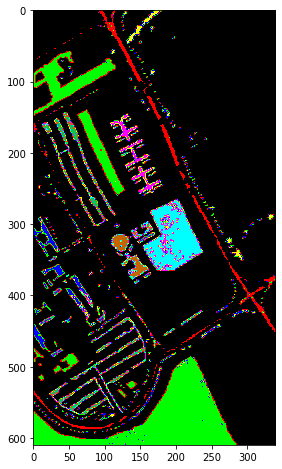

In [98]:
predict_gt = spy.imshow(classes =predict.astype(int),figsize =(8,8))

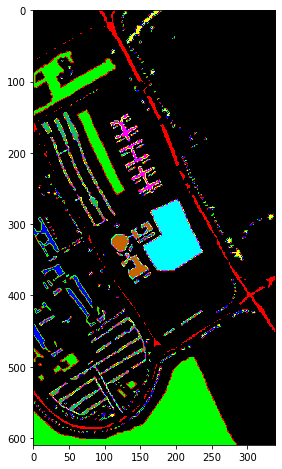

In [99]:
ground_truth = spy.imshow(classes = gt_image.astype(int),figsize =(8,8))

In [79]:
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score
from operator import truediv


In [218]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [23]:
def reports (y_pred,y_test):
    """
    定量分析
    """
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100


In [147]:
train_data

,index,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,100,101,102,label
0,91,1447,1113,973,1053,1180,1263,1285,1320,1283,...,1788,1749,1696,1708,1714,1698,1660,1643,1610,1
1,92,1203,1304,1402,1525,1586,1560,1461,1430,1434,...,1103,1096,1113,1164,1167,1109,1075,1126,1182,1
2,93,1579,1498,1299,1208,1251,1282,1291,1257,1221,...,1116,1100,1116,1122,1138,1146,1137,1145,1161,1
3,94,562,850,1020,1075,1008,914,992,998,929,...,2122,2112,2144,2142,2109,2135,2139,2130,2122,1
4,95,1188,1174,1189,1383,1451,1433,1452,1486,1518,...,1749,1728,1683,1651,1620,1582,1556,1574,1620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42771,207341,911,1038,1026,879,798,889,904,784,839,...,2632,2640,2651,2644,2629,2632,2629,2635,2634,2
42772,207342,962,764,802,862,894,951,934,883,858,...,2705,2712,2722,2688,2644,2628,2629,2627,2681,2
42773,207343,758,439,489,694,812,789,733,753,822,...,2799,2818,2828,2800,2737,2753,2751,2734,2720,2
42774,207344,1000,741,802,887,946,958,870,835,872,...,2988,3006,3008,2929,2844,2836,2870,2895,2899,2
